In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import pandana as pdn
import numpy as np
import matplotlib.pyplot as plt
import contextily as ctx
import warnings
import os
import json

warnings.filterwarnings("ignore")

In [3]:
# Load datasets
pois = gpd.read_file('/app/data/input/amenities_costanera')
grid = gpd.read_file('/app/data/input/grilla')

In [4]:
# Adjust crs
grid = grid.to_crs(pois.crs)

In [96]:
pat = gpd.read_file('/app/data/input/pois_patentes_comerciales.geojson')

pat_intersection = gpd.sjoin(pat, grid, how="left", op="intersects")
pat_intersection.dropna(subset=['grid_id'], inplace=True)
delete_types = ['INDUSTRIAL', 'PROFESIONAL ', 'PROVISORIA']
pat_intersection = pat_intersection[~pat_intersection['type'].isin(delete_types)]

df = pd.read_csv('/app/data/input/patentes_comerciales_amenities_labels.csv')
df = df[~df['category'].isin(['No clasificado', 'drop'])]

pat_with_categories = pd.merge(pat_intersection[['type', 'name']], df, on='name')

In [100]:
pat_with_categories

,type_x,name,type_y,category
0,COMERCIAL,ARRIENDO DE AUTOMOVILES Y COMPRAVENTA,COMERCIAL,Comercio
1,COMERCIAL,COMERCIALIZADORA DE ACCESORIOS,COMERCIAL,Comercio
2,COMERCIAL,FRUTERIA Y VERDULERIA,COMERCIAL,Aprovisionamiento
3,COMERCIAL,FRUTERIA Y VERDULERIA,COMERCIAL,Aprovisionamiento
4,COMERCIAL,COCINERIA,MICROEEMPRESA FAMILIAR,Comida para servir
...,...,...,...,...
10716,MICROEEMPRESA FAMILIAR,PELUQUERA,INDUSTRIAL,Servicios
10717,MICROEEMPRESA FAMILIAR,PELUQUERA,PROFESIONAL,Servicios
10718,MICROEEMPRESA FAMILIAR,PELUQUERA,PROFESIONAL,Servicios
10719,MICROEEMPRESA FAMILIAR,PELUQUERA,MICROEEMPRESA FAMILIAR,Servicios


,type,name,category
3,COMERCIAL,"REVISTAS,LIBRERIA Y VENTA AL POR MAYOR",Comercio
4,COMERCIAL,LIBRERIA,Comercio
6,COMERCIAL,PAQUETERIA,Comercio
7,COMERCIAL,BAZAR,Comercio
8,COMERCIAL,ARTS DE REGALO,Comercio
...,...,...,...
11565,MICROEEMPRESA FAMILIAR,"COMPRA VENTA DE MUEBLES, PLANTAS, ARTESANIA",Comercio
11566,MICROEEMPRESA FAMILIAR,PELUQUERA,Servicios
11567,MICROEEMPRESA FAMILIAR,MINIMERCADO ALIMENTOS PARA MASCOTAS,Aprovisionamiento
11568,MICROEEMPRESA FAMILIAR,"MINIMERCADO, FRUTAS, VERDURAS, BEB. ANALCOHOLICAS",Aprovisionamiento


In [57]:
pat_intersection[['type', 'name']].to_csv('/app/data/output/names_patentes.csv')

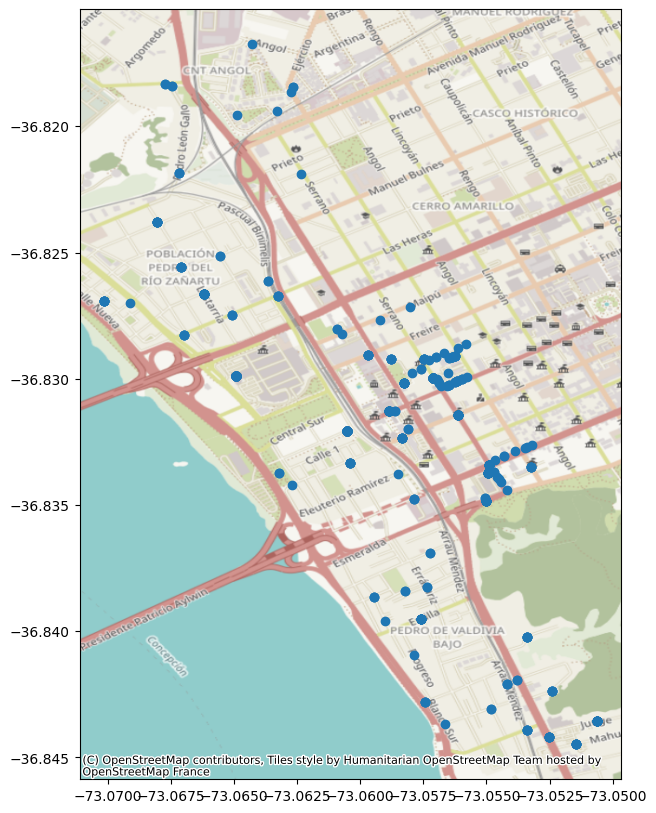

In [62]:
fig, ax = plt.subplots(figsize=(10,10))
pat_intersection.plot(ax=ax)
ctx.add_basemap(ax=ax, crs=pat_intersection.crs)

In [9]:
# Intersect both gdf to get put tag grid_id on amenities gdf
intersection = gpd.sjoin(pois, grid, how="left", op="intersects")

In [10]:
# Get only data on the interest area
intersection.dropna(subset=['grid_id'], inplace=True)

In [11]:
# Filter columns to calculate indicators
inter_cols = ['grid_id', 'type', 'Category', 'Subcategor']
intersection = intersection[inter_cols]

In [12]:
# Use marker as counter to get how many amenities are in the same square
intersection['marker'] = 1
density_per_quad = intersection.groupby(['grid_id'])['marker'].agg('sum').reset_index()
density_per_quad.rename(columns={'marker': 'density'}, inplace=True)

<Axes: >

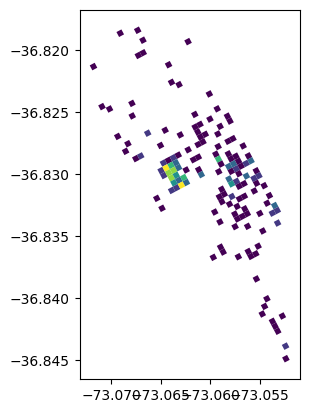

In [13]:
# Get only density and merge with geometries into the grid
density_grid = pd.merge(grid, density_per_quad[['grid_id', 'density']], on='grid_id')
density_grid.plot(column='density')

In [14]:
# Calculate the number of amenities belonging to the same category in the squares
diversity_per_quad = intersection.groupby(['grid_id', 'Category'])['marker'].agg('count').reset_index()
diversity_per_quad = diversity_per_quad.pivot(index='grid_id', columns='Category', values='marker').reset_index()
diversity_per_quad.fillna(0, inplace=True)

In [15]:
# Get only available categories in the area
categories = [col for col in diversity_per_quad.columns.tolist() if col != 'grid_id']

In [16]:
# Calculate total amenities per square and divide to get individual proportion of them
diversity_per_quad['total_amenities'] = diversity_per_quad[categories].sum(axis=1)
diversity_per_quad[categories] = diversity_per_quad[categories].div(diversity_per_quad['total_amenities'], axis=0)

In [17]:
# Calculate log and negative part of the entropy/diversity
log_diversity = np.log10(diversity_per_quad[categories]).replace(-np.inf, 0)
neg_diversity = -1*diversity_per_quad[categories]

In [18]:
# Calculate entropy/diversity
diversity_per_quad['diversity'] = (log_diversity*neg_diversity).sum(axis=1)

<Axes: >

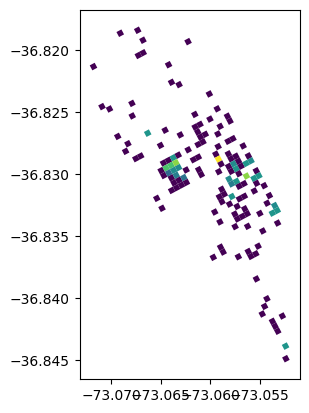

In [19]:
# Get only diversity and merge with geometries into the grid
diversity_grid = pd.merge(grid, diversity_per_quad[['grid_id', 'diversity']], on='grid_id')
diversity_grid.plot(column='diversity')

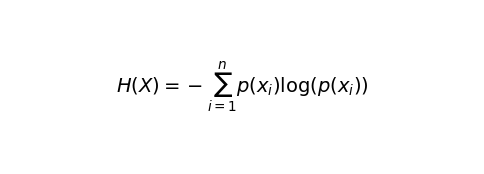

In [1]:
import matplotlib.pyplot as plt

# Crear una figura y ejes
fig, ax = plt.subplots(figsize=(6, 2))  # Ajusta el tamaño de la figura según tus preferencias

# Configurar los ejes para que no muestren nada
ax.axis('off')

# Agregar la fórmula de la entropía como texto en la figura
formula = r'$H(X) = -\sum_{i=1}^{n} p(x_i) \log(p(x_i))$'  # La fórmula en formato LaTeX
ax.text(0.5, 0.5, formula, fontsize=14, ha='center', va='center')

# Guardar la figura como una imagen PNG
# plt.savefig('entropia_formula.png', bbox_inches='tight', dpi=300)  # Ajusta el nombre y la resolución según tus preferencias

# Mostrar la figura si lo deseas
plt.show()